In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from common import OUTPUTPATH
from plotting import plot_model_partial_dependency
from models import gam_pcc
import data

In [2]:
# estimators here
STATE = np.random.RandomState(seed=1000)
gam_pcc.fit(data.x1, data.y)

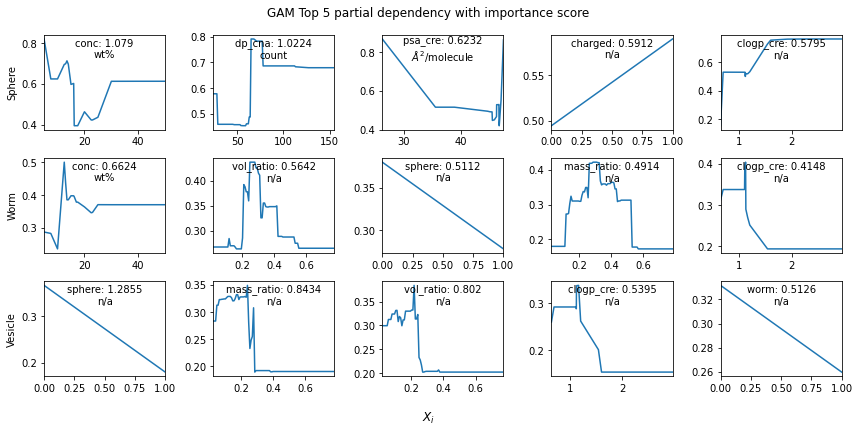

In [8]:
num_importance = 5
plot_model_partial_dependency(gam_pcc.fitted_, data1, num_importance, data.unit_comp, figsize=(12, 6),  sharey='none')
plt.suptitle('GAM Top {} partial dependency with importance score'.format(num_importance))
plt.savefig(os.path.join(OUTPUTPATH, 'GAM_Top_5_partial_dependency.pdf'), bbox_inches='tight', pad_inches=0)

plt.show()